In [24]:
#SSOR
#Same method but with a forward and backwards SOR

import numpy as np

def SORit(A,u,w,f):
    N = np.size(u)
    s0 = u[0]
    u[0] = (f[0] - np.dot(A[0,1:],u[1:]))/A[0,0]  #First step manually
    u[0] = (1-w)*s0+w*u[0]
    for i in range(1,N-1): #Do N-2 steps automatically following algorithm
        s = u[i]
        u[i] = (f[i]-np.dot(A[i,:i],u[:i])-np.dot(A[i,i+1:],u[i+1:]))/A[i,i]
        u[i] = (1-w)*s+w*u[i]
    sN = u[-1] #Do last step manually
    u[-1] = (f[-1]-np.dot(A[-1,:-1],u[:-1]))/A[-1,-1]
    u[-1] = (1-w)*sN+w*u[-1]
    return u

def SORBWit(A,u,w,f): 
    N = np.size(u)
    sN = u[-1] #Do last step manually
    u[-1] = (f[-1]-np.dot(A[-1,:-1],u[:-1]))/A[-1,-1]
    u[-1] = (1-w)*sN+w*u[-1]
    for i in reversed(range(1,N-1)): #Do N-2 steps automatically following algorithm but reversed
        s = u[i]
        u[i] = (f[i]-np.dot(A[i,:i],u[:i])-np.dot(A[i,i+1:],u[i+1:]))/A[i,i]
        u[i] = (1-w)*s+w*u[i]
    s0 = u[0]
    u[0] = (f[0] - np.dot(A[0,1:],u[1:]))/A[0,0]  #First step manually
    u[0] = (1-w)*s0+w*u[0]
    return u

#SSOR that runs N iterations
def SSOR(A,u,w,f,N):
    u0 = u
    for i in range(N):
        u0 = SORit(A,u0,w,f)
        u0 = SORBWit(A,u0,w,f)
    return u0

#Define SSOR with stopping criteria on recidual vector / source vector (r/f)
def SSORsc(A,u0,w,f,Stopping_criteria):
    u = u0
    A = A.toarray()   #otherwise everything should be sparse
    r = np.matmul(A,u) - f
    err = np.linalg.norm(r,2) / np.linalg.norm(f,2)
    it = 0  #To count number of iterations
    reduces_residuals = [err]
    while err > Stopping_criteria:
        it = it+1
        u = SORit(A,u,w,f)
        u = SORBWit(A,u,w,f)
        f_it = np.matmul(A,u)
        r = f_it - f
        err = np.linalg.norm(r,2) / np.linalg.norm(f,2)
        reduces_residuals.append(err)
        #if it > 2000:
        #    print("Over", it ,"iterations. err is: ",err)
    print("number of iterations :", it)
    return u , np.array(reduces_residuals)


In [25]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.ticker as ticker

def sourcefunc_2D(x,y):
    f = (x**2 + y**2)*np.sin(x*y)
    return f

def boundary_2D(x,y):
    b = np.sin(x*y)
    return b

def sourcefunc_3D(x,y,z):
    f = ((y**2)*(x**2) + (y**2)*(z**2) + (z**2)*(x**2))*np.sin(x*y*z)
    return f

def boundary_3D(x,y,z):
    b = np.sin(x*y*z)
    return b


In [26]:
def create_Afuex_2D(sourcefunc_2D, boundary_2D, p):

    # Here I create the T_h and I_h matrices. These have precisely the same form as in the lecture notes. Some manual
    # stuff is done since we are working without elimination of boundary conditions
    h = 1/(2**p)
    N = 1/h
    N = int(N)
    Th = sp.diags([-1, 2, -1], [-1, 0, 1], shape=(N-1, N-1)).toarray()
    T_h = np.pad(Th,1)
    T_h[0,0] = h**2
    T_h[N,N] = h**2
    Ih = sp.diags([1],[0], shape=(N-1, N-1)).toarray()
    I_h = np.pad(Ih,1)
    # The final A_h matrix is construced here. Because of the h^2 * I_{N+1} identity matrix in the very top left 
    # corner and bottom right corner I have to change four values manually from zero to 1
    A_2D = (1/(h**2))*np.kron(T_h, I_h) + (1/(h**2))*np.kron(I_h, T_h)
    A_2D[0,0] = 1
    A_2D[N,N] = 1
    A_2D[(N+1)**2-N-1,(N+1)**2-N-1] = 1
    A_2D[(N+1)**2-1,(N+1)**2-1] = 1
    
    
    # A meshgrid is created here on which I will evalute the source function. This vector is the right size for
    # the final result, but it includes every boundary value also, as evaluated through f. This is obviously wrong
    # as these boundary values should be evaluated through b, so that has to be adjusted. I therefore immediately 
    # introduce b1 and b_end as vectors which are the boundary values on the bottom and top of the grid, respectively.
    # f is also reshaped here to be a vector, not an array.
    x,y = np.mgrid[0: 1: complex(0, N+1), 0: 1: complex(0, N+1)]
    x = x.transpose()
    y = y.transpose()

    f_2D = sourcefunc_2D(x,y)
    f_2D = np.reshape(f_2D, (N+1)*(N+1))

    x_axis = np.linspace(0, 1, num = N+1)
    b1 = boundary_2D(x_axis, 0)
    b_end = boundary_2D(x_axis, 1)
    
    # In this section I overwrite the parts of the f vector that represent boundary terms and next-to-boundary terms.
    # In the first loop I overwrite the first and last parts of f with b1 and b_end, so that the bottom and top of the 
    # 'grid' are boundary values. In the second loop I overwrite values representing the left and right side of the
    # 'grid'. Of course the bottom and left boundaries are just filled with zeros, as sin(xy) is zero when either x
    # or y is zero. In the third loop I overwrite the entries which represent positions next to the right boundary. In
    # the last loop I overwrite the entries which represent positions right below the top boundary. 


    for i in range(0, N+1):
        f_2D[i] = b1[i]
        f_2D[(N+1)*N + i] = b_end[i]

    for i in range(1,N):
        f_2D[i*(N+1)] = 0
        f_2D[i*(N+1)+ N] = boundary_2D(1, i*h)
    
    for i in range(0,N-1):    
        f_2D[2*N+i*(N+1)] = f_2D[2*N+i*(N+1)] + boundary_2D(1, (i+1)*h)/(h**2)
    
    for i in range(0,N-1):     
        f_2D[(N+1)**2-1-2*N+i] = f_2D[(N+1)**2-1-2*N+i] + b_end[i+1]/(h**2)
        
    u_ex_pre_2D = boundary_2D(x,y)
    u_ex_2D = np.reshape(u_ex_pre_2D, (1, (N+1)*(N+1)))
    
    
        
    return A_2D , f_2D , u_ex_2D, N



In [27]:
def create_Afuex_3D(A_2D, sourcefunc_3D, boundary_3D, p):
    
    h = 1/(2**p)
    N = 1/h
    N = int(N)
    A = A_2D

    for i in range((N+1)**2):
        if A[i,i] == 1:
            A[i,i] = A[i,i]
        else:
            A[i,i] = 1.5*A[i,i]
    
    
    I_b1 = sp.eye(N-1).toarray()      
    I_b2 = np.pad(I_b1,1)     # Now we have a padded identity of size (N+1) x (N+1)
    I_b3 = sp.csr_matrix(I_b2)

    I_c1 = sp.diags([-1, -1], [-1, 1], shape=(N-1, N-1)).toarray()
    I_c2 = np.pad(I_c1, 1)
    I_c3 = sp.csr_matrix(I_c2)

    I_d = np.zeros((N+1,N+1))
    I_d[0,0] = 1
    I_d[N,N] = 1
    I_d2 = sp.csr_matrix(I_d)

    off_diag = sp.kron(I_b3, I_b3)

    A_3D = sp.kron(I_b3, A) + sp.kron(I_c3, (N**2)*off_diag) + sp.kron(I_d, sp.eye((N+1)**2))
    
    for i in range((N+1)**2):
        if A_3D[i,i] == 0:
            A_3D[i,i] = 1
        else:
            A[i,i] = A_3D[i,i]
            
            
            
            
    z,y,x = np.mgrid[0: 1: complex(0, N+1), 0: 1: complex(0, N+1), 0: 1: complex(0, N+1)]

    f_3D = sourcefunc_3D(x,y,z)
    f_3D = np.reshape(f_3D, (N+1)**3)

    b_3D = boundary_3D(x,y,z)
    b_3D = np.reshape(b_3D, (N+1)**3)
    
    
    for i in range(0, (N+1)**2): # Overwriting the first and last layer of the 3D cubic grid
        f_3D[i] = b_3D[i]
        f_3D[((N+1)**2)*N + i] = b_3D[((N+1)**2)*N + i]
    

    for i in range(0, (N+1)**2): # right before the last layer
        f_3D[(N-1)*(N+1)**2 + i] = f_3D[(N-1)*(N+1)**2 + i] + b_3D[N*(N+1)**2 + i]*(N**2)
        
    
    for j in range(1, N):   # for each layer j 
    
        for i in range(0,N-1): # next to boundary points on right side  
            f_3D[2*N+i*(N+1) + j*(N+1)**2] = f_3D[2*N+i*(N+1) + j*(N+1)**2] + b_3D[2*N+i*(N+1) + j*(N+1)**2 + 1]*(N**2)
    
        for i in range(0,N-1): # right below boundary points on top    
            f_3D[(N+1)**2-1-2*N+i + j*(N+1)**2] = f_3D[(N+1)**2-1-2*N+i + j*(N+1)**2] + b_3D[(N+1)**2-1-2*N+i + j*(N+1)**2 + N + 1]*(N**2)
        
        for i in range(0, N+1): # actual boundary points on top and bottom
            f_3D[i + j*(N+1)**2] = b_3D[i + j*(N+1)**2]
            f_3D[(N+1)*N + i + j*(N+1)**2] = b_3D[(N+1)*N + i + j*(N+1)**2]

        for i in range(1,N): # actual boundary points on sides
            f_3D[i*(N+1) + j*(N+1)**2] = 0
            f_3D[i*(N+1) + j*(N+1)**2 + N] = b_3D[i*(N+1)+ j*(N+1)**2 + N]
            
            
        u_ex_3D = b_3D
    
    return A_3D, f_3D, b_3D, u_ex_3D



In [28]:
#Create A,f,u_ex for various sizes 2D
data_2D = [0,0]
for p in range(2,8):    #Creating A,f,u for p. Storing as tuple (A,f,u_ex) in data_2D[p]
    A_2D , f_2D, u_ex_2D, N = create_Afuex_2D(sourcefunc_2D, boundary_2D, p)
    data_2D.append((A_2D,f_2D,u_ex_2D))

In [29]:
#Create A,f,u_ex for various sizes 3D
data_3D = [0,0]
for p in range(2,6):
    A_2D , f_2D, u_ex_2D, N = create_Afuex_2D(sourcefunc_2D, boundary_2D, p)
    A_3D, f_3D, b_3D , u_ex_3D = create_Afuex_3D(A_2D, sourcefunc_3D, boundary_3D, p)  #Creating A,f,u for p in 3D. Storing as tuple (A,f,u_ex) in data_3D[p]
    data_3D.append((A_3D,f_3D,u_ex_3D))

In [30]:
#Solve 2D with SSOR as BIM with stopping criteria 10E-10 and save residuals

from matplotlib import pyplot as plt

stopCrit = 10E-10

resplt2D = []

parr2D = [3,4,5,6] #Takes around 1m18s with p=6 included

for i in parr2D:
    Atest = data_2D[i][0]
    ftest = data_2D[i][1]
    u0test = np.zeros(np.size(ftest))   
    #print("A symmetric? :", (Atest == Atest.transpose()).all(),)
    uSSORsc , res = SSORsc(Atest,u0test,1.5,ftest,stopCrit)   #Solve with SSOR until stopping criteria. Res is array of two-norms of residuals at each iteration
    resplt2D.append( (res ) ) #Save reduced residual error


AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

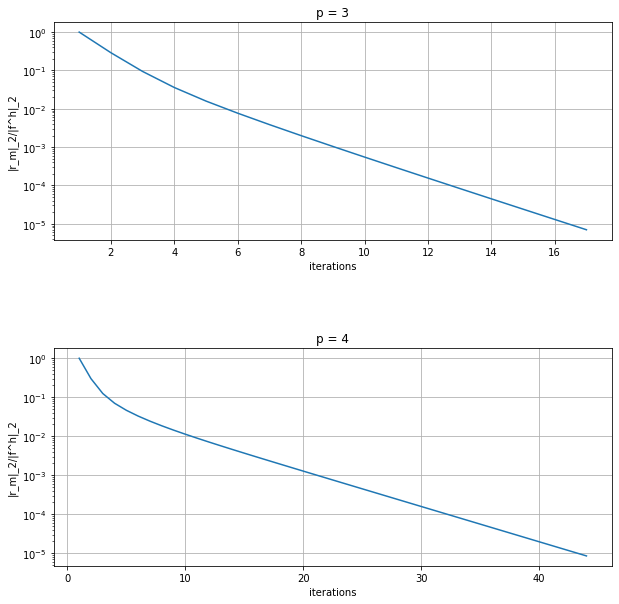

In [20]:
#Plotting the reduced residuals

fig, axs = plt.subplots(np.size(resplt2D), figsize=(10, 10))  #Creating the plots
fig.subplots_adjust(hspace = 0.5, wspace=.01)
fig.suptitle("Convergence of SSOR for 2D", fontsize=16)


for i in range(np.size(resplt2D)):
    its = np.size( resplt2D[i] )  #Find number of iterations
    itsplot = np.linspace(1,its,its) #Create x-axis with number of iterations
    axs[i].plot(itsplot,resplt2D[i])
    axs[i].set(xlabel = "iterations", ylabel = "|r_m|_2/|f^h|_2",title = "p = " + str(parr2D[i]))  #Labels and title
    axs[i].set_yscale('log')
    axs[i].grid(True)

In [26]:
#Solve 3D with SSOR as BIM with stopping criteria 10E-10 and save residuals

from matplotlib import pyplot as plt

stopCrit = 10E-10

resplt3D = []

parr3D = [2,3]

for i in parr:
    Atest = data_3D[i][0]
    ftest = data_3D[i][1]
    u0test = np.zeros(np.size(ftest))   
    #print("A symmetric? :", (Atest == Atest.transpose()).all(),)
    uSSORsc , res = SSORsc(Atest,u0test,1.5,ftest,stopCrit,True)   #Solve with SSOR until stopping criteria. Res is array of two-norms of residuals at each iteration
    resplt3D.append( (res / np.linalg.norm(ftest,2)) ) #Save reduced residual error



NameError: name 'parr' is not defined

In [ ]:
import time
N = 100   #Max number of iterations

errorvec = np.zeros(N)
timevec = np.zeros(N)
itevec = np.linspace(1,N,N)

p = 5

A = data[p-2][0]
f = data[p-2][1]
u_ex = data[p-2][2]

for i in range(N):
    u0 = np.zeros(np.size(f))
    t = time.time()
    u = SSOR(A,u0,1.5,f,i)
    t = time.time()-t
    timevec[i] = t
    error = np.amax(np.absolute(u_ex-u))
    errorvec[i] = error


In [ ]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2)
fig.suptitle('time and error versus iterations for SSOR method and with p= 5')
axs[0].plot(itevec, np.log(errorvec))
axs[0].set(ylabel="log(error)")
axs[1].plot(itevec, timevec)
axs[1].set(ylabel="time [s]")

print(errorvec[N-1])

In [ ]:
#Solve for SSOR with omega = 1.5

for i in data:
    t = time.time()
    u = SSOR(i[0],u0,1.5,i[1],)
    u = DirSolver(i[0],i[1])
    t = time.time()-t
    error = np.amax(np.absolute(i[2]-u))
    print("Error: ", error, "time: ", t)

In [ ]:
#TODO
#SOLVE for    2D p = 3,5,7    3D 2,4,6
#PLOT Ax^m-f / f for that data